In [1]:
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForTokenClassification, pipeline
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
from glob import glob
import pandas as pd
from tqdm.autonotebook import tqdm
import umap.plot
import pandas as pd
import matplotlib.pyplot as plt
import jsonlines
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/pfs/data5/home/tu/tu_tu/tu_kmpaj01/miniforge3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/pfs/data5/home/tu/tu_tu/tu_kmpaj01/miniforge3/envs/torch/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/pfs/data5/home/tu/tu_tu/tu_kmpaj01/miniforge3/envs/torch/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnin

In [2]:
def pad_arrays(arrays):
  """Pads all arrays in a list to the same length with 0s.
  """  
  max_len = max(len(arr) for arr in arrays)
  padded_arrays = [np.pad(arr, (0, max_len - len(arr)), mode='constant', constant_values=0) for arr in arrays]
  return padded_arrays


In [3]:
def pad_sequences(arrays):
  """Pads a list of numpy arrays to the same shape.

  Args:
    arrays: A list of NumPy arrays. All arrays must have the same
      dimensionality (rank).

  Returns:
    A list of padded NumPy arrays. The arrays will all have the same
    shape as the array with the largest shape in the original list.
  """
  max_len = np.max([arr.shape[0] for arr in arrays])
  padded_arrays = []
  for arr in arrays:
    padding_len = max_len - arr.shape[0]
    padded_array = np.pad(arr, ((padding_len, 0), (0, 0)), mode='constant')
    padded_arrays.append(padded_array)
  return padded_arrays

## Initial tests (do not run)

In [31]:
path = "../NER_output/STRAIN"

# Load your fine-tuned model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(path, model_max_length=512)
# model = AutoModel.from_pretrained(path)
model = AutoModelForTokenClassification.from_pretrained(path)


KeyboardInterrupt



In [ ]:
with open("../NER/STRAIN/train.jsonls") as f:
    data = json.load(f)
sentences = []
for s in data:
    sen = s["data"]["text"]
    sentences.append(sen)

In [ ]:
# Prepare to extract embeddings
model.eval()  # Set model to evaluation mode
embeddings = []

# Process the dataset and extract embeddings
with torch.no_grad():
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors="pt", padding=True)
        outputs = model(**inputs)

        # Extract embeddings from the desired layer (here, the last hidden state)
        embeddings.append(outputs) # .mean(dim=1)

In [ ]:
outputs

In [ ]:
# Prepare to extract embeddings
model.eval()  # Set model to evaluation mode
embeddings = []

# Process the dataset and extract embeddings
with torch.no_grad():
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors="pt", padding=True)
        outputs = model(**inputs)

        # Extract embeddings from the desired layer (here, the last hidden state)
        embeddings.append(outputs.last_hidden_state[0].numpy()) # .mean(dim=1)

In [ ]:
embeddings[0]

In [ ]:
fit = umap.UMAP()
u = fit.fit_transform(dembeddings[0])

## Do it instead with the feature extraction method (do not run)

In [ ]:
ner = "STRAIN"

In [ ]:
path= f"../NER_output/{ner}"

tokenizer = AutoTokenizer.from_pretrained(path, model_max_length=512)
model = AutoModelForTokenClassification.from_pretrained(path)

fe = pipeline(task='feature-extraction', model=model, tokenizer=tokenizer,
               aggregation_strategy="average", device=1)


In [ ]:
features = []
for sentence in sentences:
    features.append(fe(sentence)[0])


In [ ]:
flat = [np.array(i).flatten() for i in features]

In [ ]:
flat_pad = pad_arrays(flat)

In [ ]:
fit = umap.UMAP()
u = fit.fit_transform(flat_pad)

In [ ]:
plt.scatter(u[:,0],u[:,1])

## Do all models at once (do not run)

In [63]:
l = []
# Load models and tokenizers outside the loop to avoid reloading for each NER
loaded_models_tokenizers = {
    ner: (
        AutoTokenizer.from_pretrained(f"../NER_output/{ner}", model_max_length=512),
        AutoModelForTokenClassification.from_pretrained(f"../NER_output/{ner}")
    ) for ner in ners
}

for ner in tqdm(ners, desc="Processing NER models"):
    with open(f"../NER/{ner}/test.jsonls") as f:
        data = json.load(f)
    sentences = [s["data"]["text"] for s in data]
    
    tokenizer, model = loaded_models_tokenizers[ner]
    
    fe = pipeline(task='feature-extraction', model=model, tokenizer=tokenizer,
                   aggregation_strategy="average", device=0)
    features = [np.array(fe(sentence)[0]) for sentence in sentences]
    
    flat = [feature.flatten() for feature in features]
    flat_pad = pad_arrays(flat)
    df = pd.DataFrame(flat_pad)
    df["ner"] = ner
    l.append(df)

Processing NER models:   0%|          | 0/12 [00:00<?, ?it/s]

In [64]:
dfs = pd.concat(l,axis=0)
dfs = dfs.dropna(axis=1)

In [65]:
# Create a UMAP object and fit it
mapper = umap.UMAP(metric="cosine").fit(dfs.iloc[:, :-1])

# Get the labels from the last column of the dataframe
labels = dfs.iloc[:, -1]


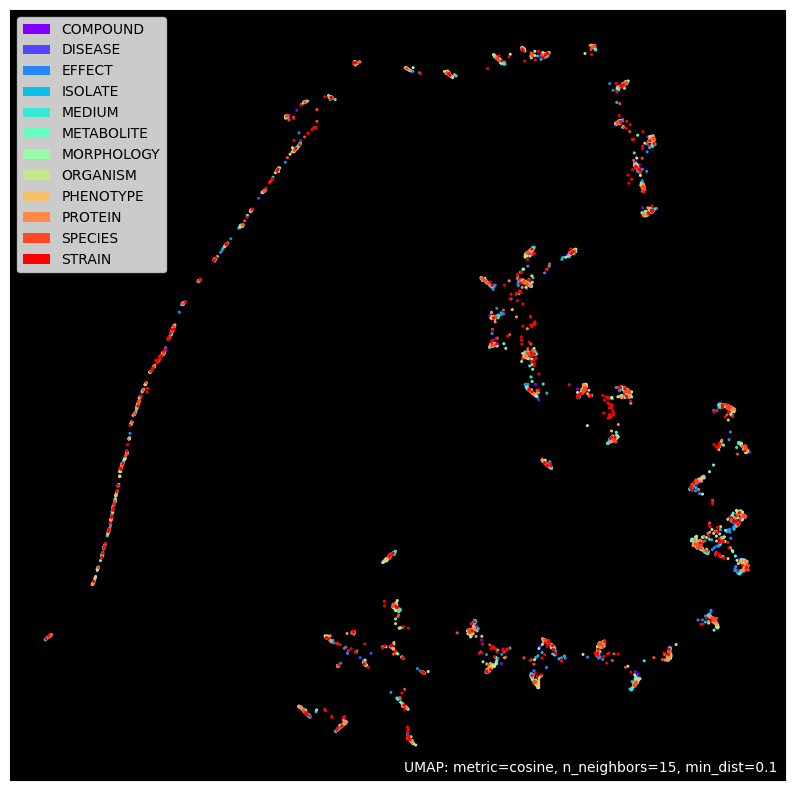

In [66]:
# Plot using UMAP's plotting API, mapping labels to colors
p = umap.plot.points(mapper, labels=labels, theme='fire', width=1000, height=1000)

Processing NER models:   0%|          | 0/12 [00:00<?, ?it/s]

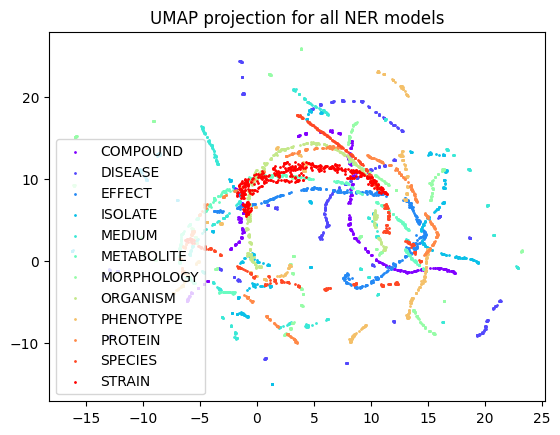

In [67]:
# Load models and tokenizers outside the loop to avoid reloading for each NER
loaded_models_tokenizers = {
    ner: (
        AutoTokenizer.from_pretrained(f"../NER_output/{ner}", model_max_length=512),
        AutoModelForTokenClassification.from_pretrained(f"../NER_output/{ner}")
    ) for ner in ners
}

# Initialize UMAP and figure for plotting
fit = umap.UMAP(metric="cosine")
plt.figure()

colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(ners))))

for ner in tqdm(ners, desc="Processing NER models"):
    with open(f"../NER/{ner}/test.jsonls") as f:
        data = json.load(f)
    sentences = [s["data"]["text"] for s in data]
    
    tokenizer, model = loaded_models_tokenizers[ner]
    
    fe = pipeline(task='feature-extraction', model=model, tokenizer=tokenizer,
                   aggregation_strategy="average", device=0)
    features = [np.array(fe(sentence)[0]) for sentence in sentences]
    
    flat = [feature.flatten() for feature in features]
    flat_pad = pad_arrays(flat)
    
    # Apply UMAP to the result of each model
    u = fit.fit_transform(flat_pad)
    
    # Plot the result for each model on the same axes with different colors
    plt.scatter(u[:,0], u[:,1], color=next(colors), label=ner,s=1)

plt.title("UMAP projection for all NER models")
plt.legend()
plt.show()


## NER (run from here)

In [4]:
ners =["COMPOUND", "DISEASE", "EFFECT","ISOLATE","MEDIUM","ORGANISM","PHENOTYPE","STRAIN","SPECIES"]

In [18]:
l = []
# Load models and tokenizers outside the loop to avoid reloading for each NER
loaded_models_tokenizers = {
    ner: (
        AutoTokenizer.from_pretrained(f"../NER_output/{ner}", model_max_length=512),
        AutoModelForTokenClassification.from_pretrained(f"../NER_output/{ner}")
    ) for ner in ners
}

for ner in tqdm(ners, desc="Processing NER models"):
    with open(f"../NER/{ner}/train.jsonls") as f:
        data = json.load(f)
    sentences = [s["data"]["text"] for s in data]
    
    tokenizer, model = loaded_models_tokenizers[ner]
    
    fe = pipeline(task='feature-extraction', model=model, tokenizer=tokenizer,
                   aggregation_strategy="average", device=0)
    features = [np.array(fe(sentence)[0]).mean(axis=0) for sentence in sentences]
    
    # flat = [feature.flatten() for feature in features]
    # flat_pad = pad_arrays(flat)
    df = pd.DataFrame(features)
    df["ner"] = ner
    l.append(df)

Processing NER models: 100%|██████████| 9/9 [03:45<00:00, 25.04s/it]


In [19]:
dfs = pd.concat(l,axis=0)

In [42]:
# Create a UMAP object and fit it
mapper = umap.UMAP(n_neighbors=20,min_dist=0.05).fit(dfs.iloc[:, :-1])
#mapper = umap.UMAP().fit(dfs.iloc[:, :-1])

# Get the labels from the last column of the dataframe
labels = dfs.iloc[:, -1]

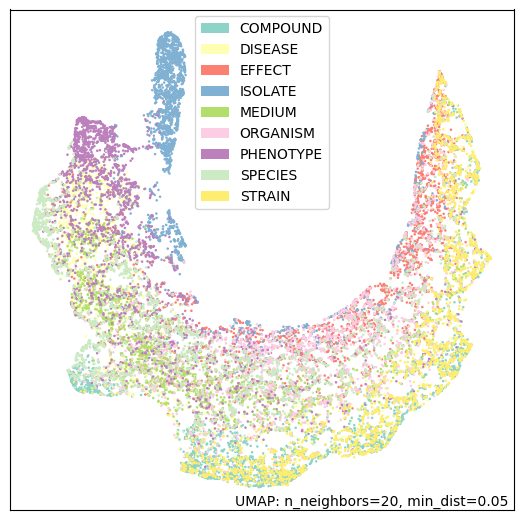

In [44]:
# Plot using UMAP's plotting API, mapping labels to colors
p = umap.plot.points(mapper, labels=labels, color_key_cmap='Set3',width=650, height=650)
plt.savefig("figures/predictions/umap_ner.pdf")

## RE

In [9]:
import yaml

with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [10]:
rels = config["rel_labels"]

In [11]:
l = []
loaded_models_tokenizers = {
    rel: (
        AutoTokenizer.from_pretrained(f"../REL_output/{rel}"),
        AutoModelForTokenClassification.from_pretrained(f"../REL_output/{rel}")
    ) for rel in rels
}

for rel in tqdm(rels, desc="Processing REL models"):
    with jsonlines.open(f"../REL/{rel}/train.json") as reader:
        data = [obj for obj in reader]
    sentences = [s["sentence"] for s in data]
    
    tokenizer, model = loaded_models_tokenizers[rel]
    
    fe = pipeline(task='feature-extraction', model=model, tokenizer=tokenizer,
                   aggregation_strategy="average", device=0)
    features = [np.array(fe(sentence)[0]).mean(axis=0) for sentence in sentences]

    df = pd.DataFrame(features)
    df["rel"] = rel
    l.append(df)

Processing REL models: 100%|██████████| 17/17 [03:24<00:00, 12.02s/it]


In [12]:
dfs = pd.concat(l,axis=0)

In [13]:
dfs["non_strain_ner"] = dfs["rel"].str.split(":",expand=True)[0].str.split("-").apply(lambda x: [i for i in x if i != "STRAIN"]).apply(lambda x: x[0] if len(x) == 1 else x)

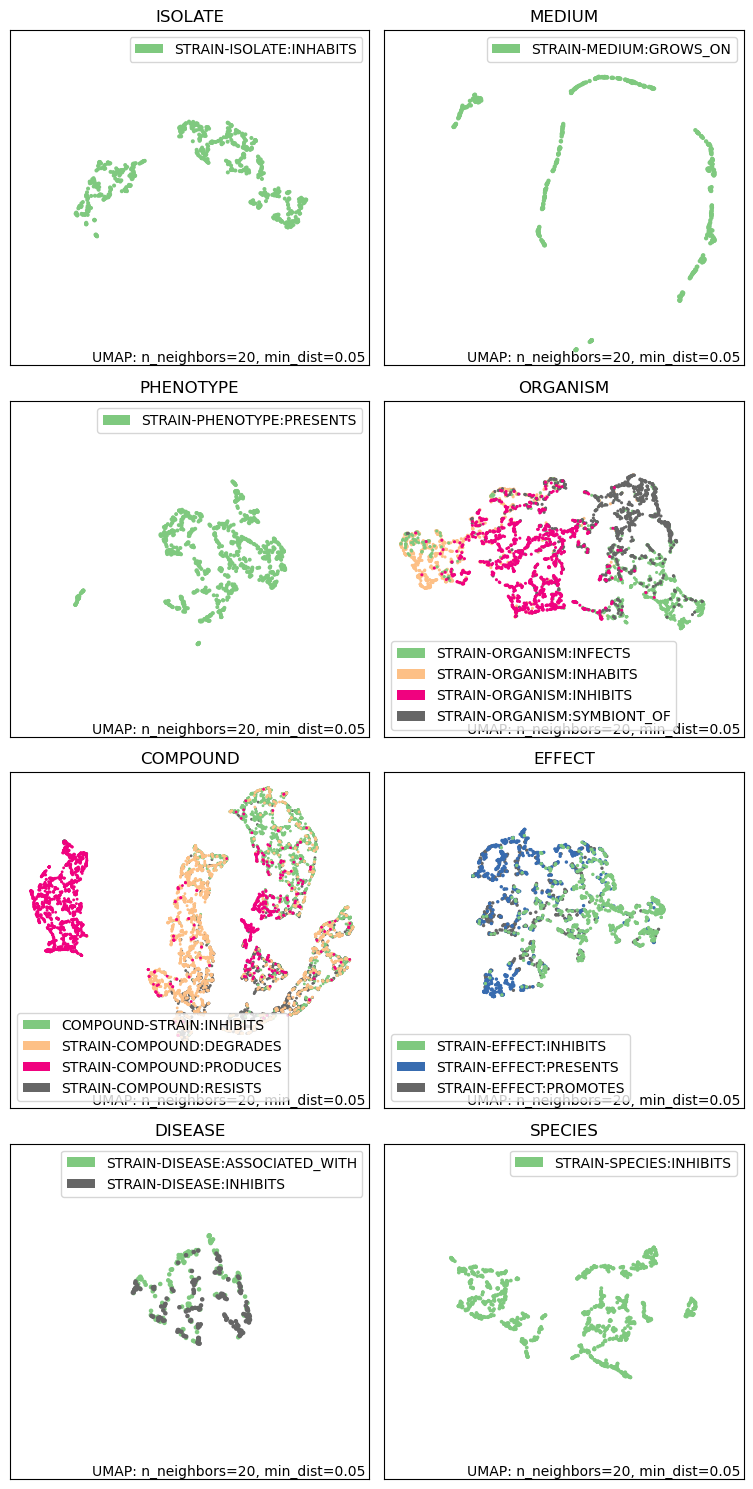

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 15), sharex=True, sharey=True)
axes = axes.flatten()

unique_non_strain_ner = dfs["non_strain_ner"].unique()

for i, non_strain_ner in enumerate(unique_non_strain_ner):
    if i >= 12:  # Only plot the first 12 to fit the grid
        break
    # Filter the dataframe for the current non_strain_ner
    df_filtered = dfs[dfs["non_strain_ner"] == non_strain_ner]
    
    # Create a UMAP object and fit it
    mapper = umap.UMAP(n_neighbors=20, min_dist=0.05).fit(df_filtered.iloc[:, :-2])  # Exclude the last two columns (rel and non_strain_ner)
    
    # Get the labels from the 'rel' column
    labels = df_filtered["rel"]
    
    # Plot using UMAP's plotting API, mapping labels to colors
    umap.plot.points(mapper, labels=labels, color_key_cmap='Accent', ax=axes[i])
    axes[i].set_title(non_strain_ner)

plt.tight_layout()
plt.savefig("figures/predictions/umap_rel_grouped_entity.pdf")

In [24]:
dfs["relation"] = dfs.rel.str.split(":",expand=True)[1]

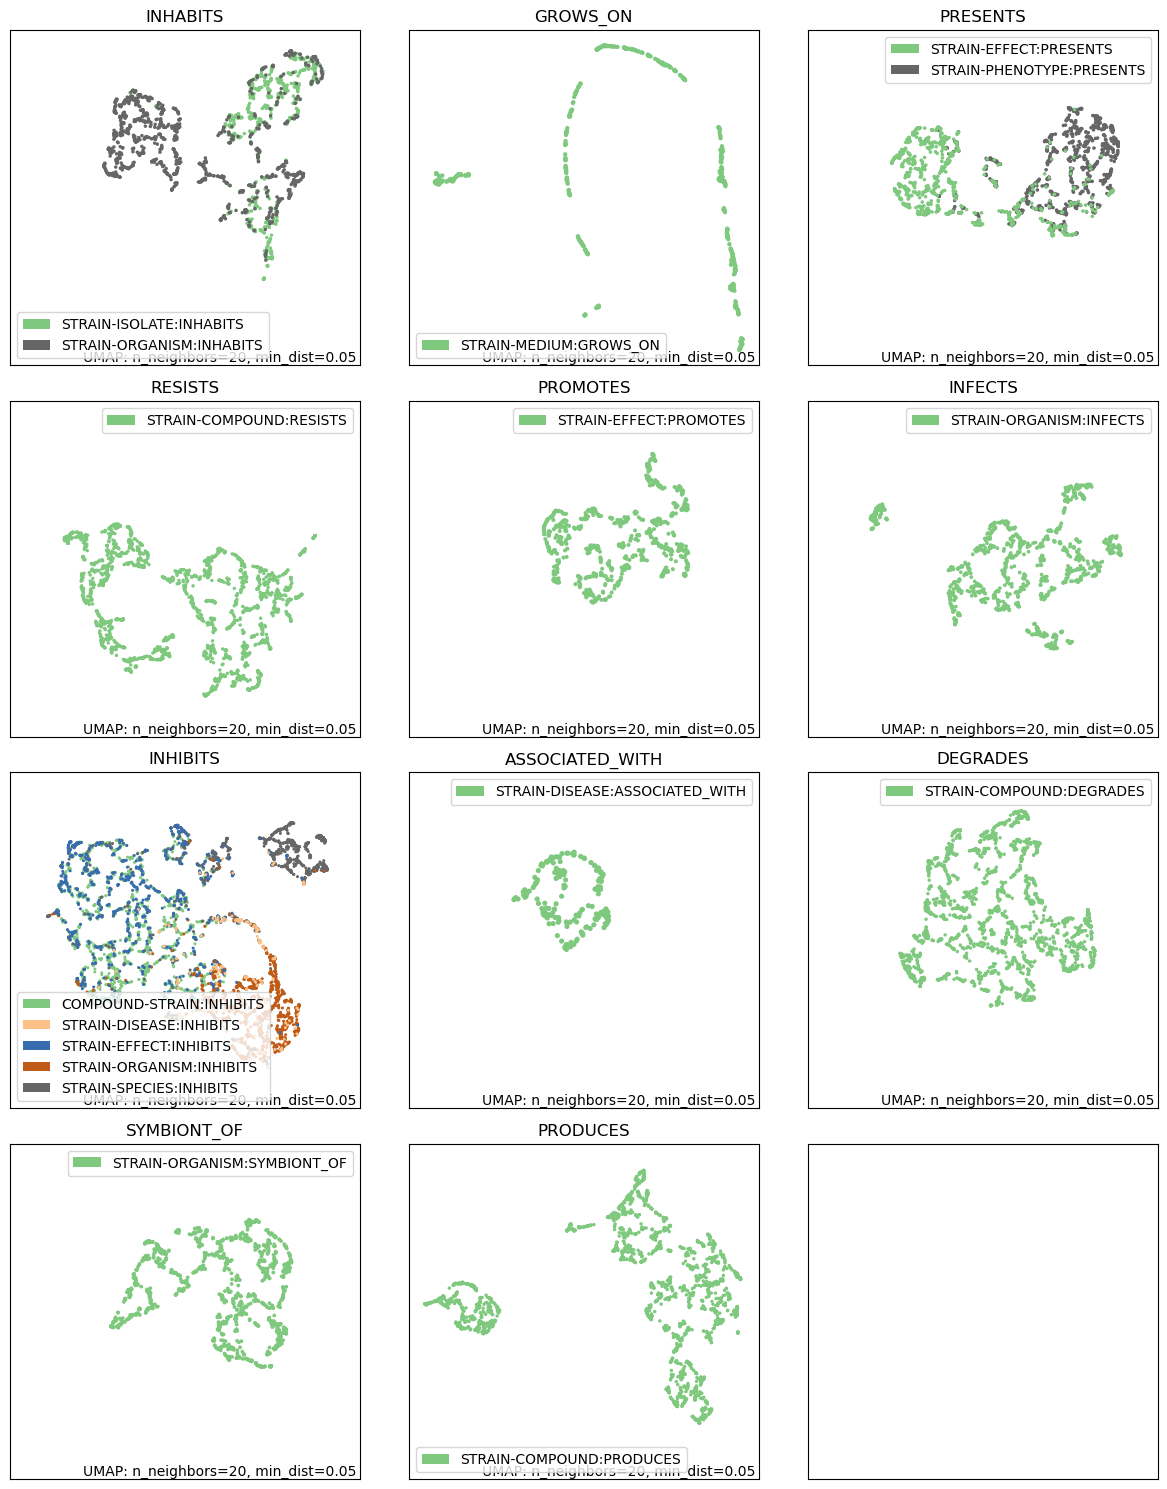

In [25]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 15), sharex=True, sharey=True)
axes = axes.flatten()

unique_relation = dfs["relation"].unique()

for i, relation in enumerate(unique_relation):
    if i >= 12:  # Only plot the first 12 to fit the grid
        break
    # Filter the dataframe for the current relation
    df_filtered = dfs[dfs["relation"] == relation]
    
    # Create a UMAP object and fit it
    mapper = umap.UMAP(n_neighbors=20, min_dist=0.05).fit(df_filtered.iloc[:, :-3])  # Exclude the last two columns (rel and relation)
    
    # Get the labels from the 'rel' column
    labels = df_filtered["rel"]
    
    # Plot using UMAP's plotting API, mapping labels to colors
    umap.plot.points(mapper, labels=labels, color_key_cmap='Accent', ax=axes[i])
    axes[i].set_title(relation)

plt.tight_layout()
plt.savefig("figures/predictions/umap_rel_grouped_relation.pdf")
